In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
Path = "drive/Shared drives/Data_Mining_Final_Project/"

In [3]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import numpy as np

In [7]:
# parameters
batch_size = 32
num_epochs = 20
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = Path+"new_models/"
dataset_path = Path+"Emotion_dataset/fer2013.csv"
image_size=(48,48)

In [8]:
def load_fer2013():
        data = pd.read_csv(dataset_path)

        num_samples = 4002
        class_5_samples = data[data["emotion"] == 5].sample(num_samples)
        other_classes_samples = pd.concat([data[data["emotion"] == class_idx].sample(num_samples, replace=True) for class_idx in range(7) if class_idx != 5])
        selected_samples = pd.concat([class_5_samples, other_classes_samples])
        data = selected_samples.sample(frac=1)

        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        # emotions = pd.get_dummies(data['emotion'])[[]].values
        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions

def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model


In [9]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# model parameters/compilation
model = mini_XCEPTION(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])


# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(patience/4), verbose=1)
trained_models_path = base_path + 'model2.hdf5'
model_names = trained_models_path 
#+ '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

# loading dataset
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
num_samples, num_classes = emotions.shape
#xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)
x_train_val, x_test, y_train_val, y_test = train_test_split(
    faces, emotions, test_size=0.2, shuffle=True)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.25, shuffle=True)

history=model.fit(data_generator.flow(x_train, y_train,batch_size),
                    steps_per_epoch=len(x_train) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(x_val,y_val))



Epoch 1/20
525/525 [============================>.] - ETA: 0s - loss: 1.9489 - accuracy: 0.2656
Epoch 1: val_loss improved from inf to 1.85194, saving model to drive/Shared drives/Data_Mining_Final_Project/new_models/model2.hdf5
525/525 [==============================] - 24s 30ms/step - loss: 1.9493 - accuracy: 0.2655 - val_loss: 1.8519 - val_accuracy: 0.3013 - lr: 0.0010
Epoch 2/20
526/525 [==============================] - ETA: 0s - loss: 1.7105 - accuracy: 0.3633
Epoch 2: val_loss did not improve from 1.85194
525/525 [==============================] - 15s 28ms/step - loss: 1.7105 - accuracy: 0.3633 - val_loss: 1.9230 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 3/20
526/525 [==============================] - ETA: 0s - loss: 1.5814 - accuracy: 0.4139
Epoch 3: val_loss improved from 1.85194 to 1.56501, saving model to drive/Shared drives/Data_Mining_Final_Project/new_models/model2.hdf5
525/525 [==============================] - 15s 29ms/step - loss: 1.5814 - accuracy: 0.4139 - val_loss: 

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

# print the training accuracy
print('Training loss:', history.history['loss'][-1])
print('Training accuracy:', history.history['accuracy'][-1])

# print the validation accuracy and loss
print('Validation loss:', history.history['val_loss'][-1])
print('Validation accuracy:', history.history['val_accuracy'][-1])


# evaluate the model on the test data
scores = model.evaluate(x_test, y_test, verbose=0)

# calculate the metrics
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1) # Convert predicted probabilities to class labels
y_test = np.argmax(y_test, axis=1) # Convert multilabel-indicator targets to class labels

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
class_report = classification_report(y_test, y_pred)
print(class_report)

print('Test accuracy:', accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)


Training loss: 1.0958551168441772
Training accuracy: 0.5928129553794861
Validation loss: 1.1750954389572144
Validation accuracy: 0.5636266469955444
176/176 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.40      0.53      0.46       783
           1       0.81      0.76      0.79       787
           2       0.37      0.37      0.37       794
           3       0.77      0.73      0.75       794
           4       0.46      0.29      0.36       802
           5       0.70      0.74      0.72       789
           6       0.51      0.56      0.53       854

    accuracy                           0.57      5603
   macro avg       0.57      0.57      0.57      5603
weighted avg       0.57      0.57      0.57      5603

Test accuracy: 0.5686239514545779
F1 score: 0.566751897972947
Precision: 0.5738748305897134
Recall: 0.5686239514545779


[[415  55 105  23  49  45  91]
 [ 93 601  37  10  35   1  10]
 [163  22 295  27  81 111  95]
 [ 58  15  34 577  19  37  54]
 [151  20 142  41 235  30 183]
 [ 47  13  89  25   8 587  20]
 [114  14  90  51  79  30 476]]


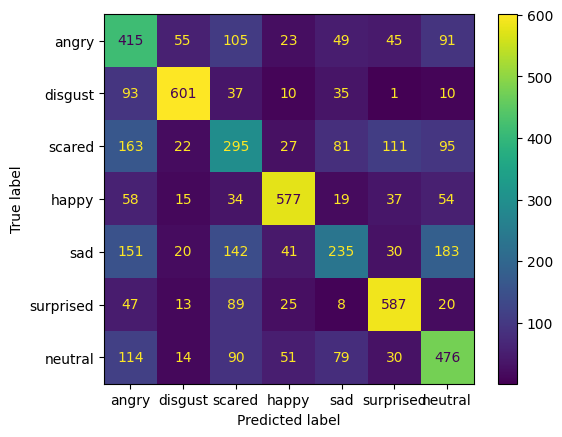

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
class_names = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]
# Display the confusion matrix as a heatmap
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
display.plot()

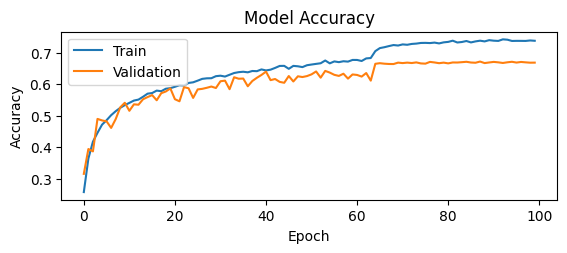

In [ ]:
import matplotlib.pyplot as plt

# plot training, validation, and test accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

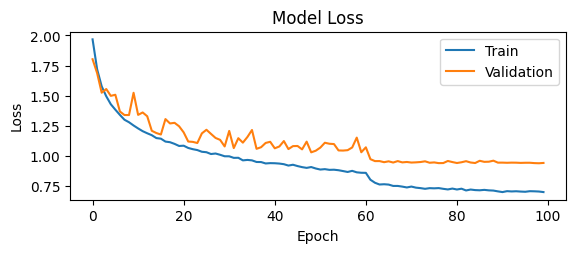

In [ ]:
# plot training, validation, and test loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()